In [3]:
import numpy as np
import pandas as pd
import networkx as nx
import nltk
import powerlaw
from operator import itemgetter
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import seaborn as sns; sns.set()

In [4]:
# Load data
comic_graph = nx.read_gpickle('../Data/full_graph_directed.pickle')

con_comp = sorted(nx.weakly_connected_components(comic_graph), key = len, reverse = True)
comic_graph_GCC = comic_graph.subgraph(con_comp[0]).copy()

# Part 1: Visualization and Statistics of the Network

## Part 1a: Basic Statistics of the Network

**What is the number of nodes in the network?**

In [5]:
N = len(comic_graph_GCC.nodes())
print('The network consists of', N ,'nodes.')

The network consists of 2593 nodes.


**What is the number of links?**

In [6]:
L = len(comic_graph_GCC.edges())
print('The network consists of', L ,'edges.')

The network consists of 24975 edges.


**What is the number of links connecting Marvel and DC? Explain what those links mean?**

In [8]:
marvel_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'Marvel']
dc_nodes = [superhero for superhero, univserse in nx.get_node_attributes(comic_graph_GCC, 'Universe').items() if univserse == 'DC']


num_of_links_between_marvel_dc = []
num_of_links_between_dc_marvel = []

for marvel_node, dc_node in zip(marvel_nodes, dc_nodes):
    edges_from_marvel_node = list(dict(comic_graph_GCC[marvel_node]).keys())
    
    # calculate the number of links between the marvel node and the DC nodes.
    num_of_links_from_marvel_node_to_dc_nodes = sum([edge in dc_nodes for edge in edges_from_marvel_node])
    num_of_links_between_marvel_dc.append(num_of_links_from_marvel_node_to_dc_nodes)
    
    
    edges_from_dc_node = list(dict(comic_graph_GCC[dc_node]).keys())
    num_of_links_from_dc_node_to_marvel_nodes = sum([edge in marvel_nodes for edge in edges_from_dc_node])
    num_of_links_between_dc_marvel.append(num_of_links_from_dc_node_to_marvel_nodes)
    

print('There are', sum(num_of_links_between_marvel_dc), 'edges from the Marvel universe to the DC universe.')
print('There are', sum(num_of_links_between_dc_marvel), 'edges from the DC universe to the Marvel universe.')

There are 338 edges from the Marvel universe to the DC universe.
There are 468 edges from the DC universe to the Marvel universe.


From the result above it is clear that there is only a few edges that connect the two universes.

**Who are top 5 most connected characters? (Report results for in-degrees and out-degrees).**

Let's explore the five superheros with highest in-degree:

In [10]:
top5_in = dict(sorted(dict(comic_graph_GCC.in_degree).items(), key = itemgetter(1), reverse = True)[:5])
top5_in

{'Superman': 589,
 'Batman': 574,
 'Spider-Man': 479,
 'Captain America': 430,
 'Iron Man': 355}

The 5 super heroes with the largest in-degree are by most people insant recognisable. They are the most popular super heroes and have been aloung for a long. More specifically 
* Superman was created in 1938, 
* Batman was created in  1938,
* Spider-Man was created in  1962,
* Captain America was created in  1940, and
* Iron Man was created in 1963. 
[source: wiki ;-)]

All the above superheroes stars in their very own comic books series. In constrast the less popular superheroes are introduced as side kick or villian in the same comic books. It therefore makes sense that these old guys have so many references to other superheroes.


Let's explore the five superheros with highest out-degree:

In [131]:
top5_out = dict(sorted(dict(comic_graph_GCC.out_degree).items(), key = itemgetter(1), reverse = True)[:5])
top5_out

{'Barracuda (II)': 67,
 'Belthera, Queen': 59,
 'Deathstroke': 59,
 'Butcher': 54,
 'Venom': 52}

These super heroes requies a more trained super hero enthusiast to recognize. It's not apparently clear why they have a high out-degree. However, if one investiages the length of the Wikipedia articles it's clear that these superheros have long articles. 

In [134]:
for super_hero in top5_out.keys():
    print(super_hero, ': Wikipidea article consists of ', comic_graph_GCC.nodes[super_hero]['length_of_content'], 'words.') 

Barracuda (II) : Wikipidea article consists of  13893 words.
Belthera, Queen : Wikipidea article consists of  9709 words.
Deathstroke : Wikipidea article consists of  12739 words.
Butcher : Wikipidea article consists of  5208 words.
Venom : Wikipidea article consists of  19744 words.


compared to the mean number of words for all superheros displayed in the cell below:

In [128]:
np.array([comic_graph_GCC.nodes[node]['length_of_content'] for node in comic_graph_GCC.nodes]).mean()

2820.431932124952

In general there is strong relationship between the length of the Wikipidea article and the number of refences to other superheros. In the cell below is a plot genearted which diplays a scatter plot that shows the relationship between the number of links to other superheros a wikidia articles refers to and the length of that article.

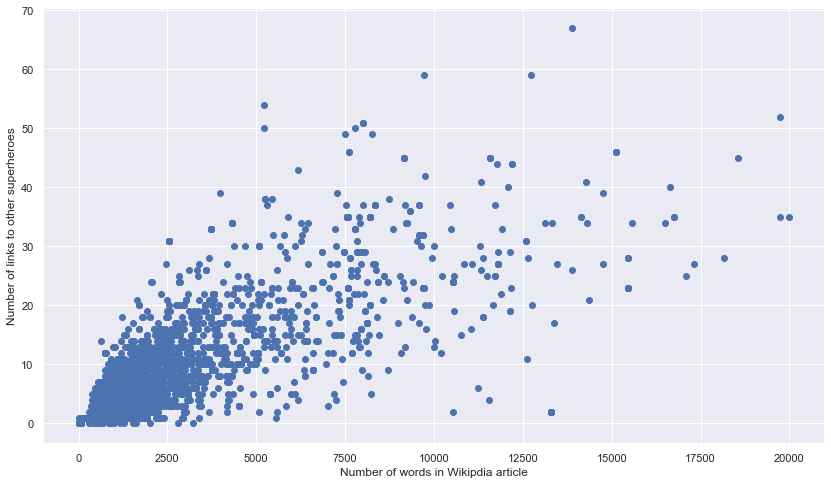

In [11]:
LEN = [comic_graph_GCC.nodes[node]['length_of_content'] for node in comic_graph_GCC.nodes]
OD = [v for k,v in comic_graph_GCC.out_degree]


plt.figure(figsize = (14,8))
plt.scatter(LEN,OD)
plt.ylabel('Number of links to other superheroes')
plt.xlabel('Number of words in Wikipdia article')
plt.show()

The correlation is between the length and the number links to other super heros is calculated in the below cell.

In [12]:
print(f"The correlation is {np.corrcoef(LEN,OD)[0,1]}")

The correlation is 0.758744963832185


**Plot the in- and out-degree distributions.**

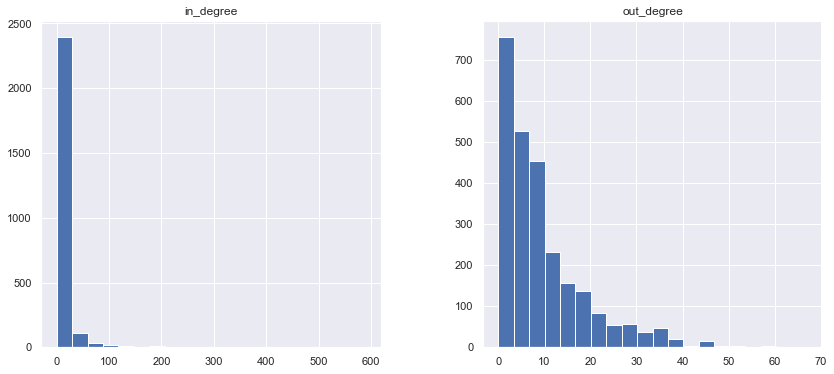

In [13]:
degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(comic_graph_GCC.in_degree).values())),
    'out_degree' : np.array(list(dict(comic_graph_GCC.out_degree).values()))
})
hist = degree_distribution[['in_degree', 'out_degree']].hist(bins=20, figsize=(14,6))

Hmmm ... this look like something that would be worth exploring in log-log plot. 

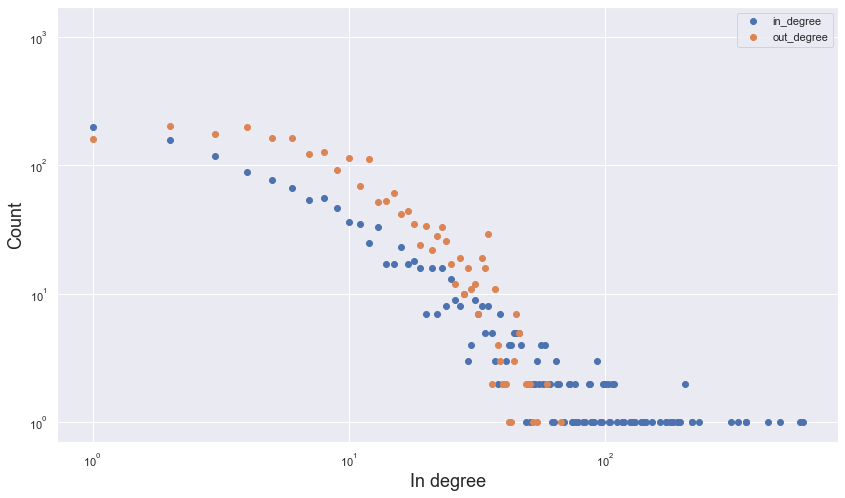

In [14]:
# Initialize plot
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize = (14,8))
degree_distribution['in_degree'].value_counts().to_frame().plot(style='o', ax = ax1)
degree_distribution['out_degree'].value_counts().to_frame().plot(style='o', ax = ax1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("k", fontsize = 18)
ax1.set_ylabel("Count", fontsize = 18)
ax1.set_xlabel("In degree", fontsize = 18)
plt.show()

Indeed the log-log plot revails more information about the difference in distribution between in and out degree. From the plot it appear as the *in degree* distribution acts scale free whereas the the *out degree* distribution act more random. This hypothesis can be explored further by investigating exponent of the degree distribution using the `powerlow` library.

In [15]:
in_degree_exponent = powerlaw.Fit(degree_distribution.in_degree.values).alpha
out_degree_exponent = powerlaw.Fit(degree_distribution.out_degree.values).alpha

Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/Users/IdaRiis/opt/anaconda3/envs/social_graphs/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [16]:
print('In degree exponent : ', round(in_degree_exponent, 3))
print('Out degree exponent : ', round(out_degree_exponent, 3))

In degree exponent :  2.354
Out degree exponent :  11.298


As expected the in degree distribution resmaple a Scale-free network as $2 < \gamma_{in} = 2.354 < 3$. Whereas the out degree distribution are harder to diagnose. The distribution has a heavy tail but deviate from being scale-free given $\gamma_{out} = 11.298 > 3$.

**Compare the degree distribution to a random network with the same number of nodes and probability of connection $p$.**

To initilize the random network with the same number of nodes and probability of connection the average degree is needed. Though the distribution of in degree and out degree are very different for super hero network the average degree is the same. 
$$\langle k_{in} \rangle = \langle k_{out} \rangle$$
This makes good sense good sense as outgoing edge from note is the ingoing edge for another node. This can further be verified by examining the mean of `degree_distribution` dataframe as seen in the cell below. 

In [24]:
degree_distribution.mean()

in_degree     9.631701
out_degree    9.631701
dtype: float64

The average degree of $\langle k_{in} = 9.631701 \rangle$ Can be utilized to calculate the probability that two nodes are connected. From [1, eq. (3.3)] it is know that $\langle k \rangle = p (N-1)$. In this equation $p$ can be isolated and results in the following expression:
$$p = \frac{\langle k \rangle}{N-1}.$$
As the mean, which is $\langle k \rangle$, in the Poisson distribution is equal $\lambda$ the values can easily be inserted and it this specific case it yields:
$$p = \frac{9.631701}{2593} = 0.003714500964.$$

With that number and recalling the GCC contains $N=2593$ nodes we can create the random graph.  

In [11]:
rg = nx.erdos_renyi_graph(n = N, p = 0.003714500964, seed=123, directed=True)

Now we can examine the distribution of in and out degree. As expected the two distributions take the form of Posison distribtuion with mean around $9.63$. 

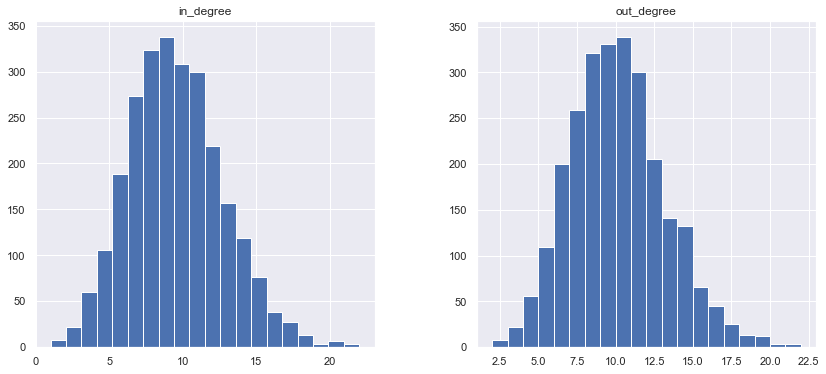

In [12]:
rg_degree_distribution = pd.DataFrame({
    'in_degree' : np.array(list(dict(rg.in_degree).values())),
    'out_degree' : np.array(list(dict(rg.out_degree).values()))
})
hist = rg_degree_distribution.hist(bins=20, figsize=(14,6))

The two graphs, the GCC of super heroes and the random graph, have different distributions because the super hero graph is **not** a random graph.


## Part 1b: Visualization of the Network


**Create a nice visualization of the total network with the following properties**
  - Color nodes according to universe
  - Scale node-size according to degree
  - Whatever else you feel like.
  - If you can get it to work, get node positions based on the Force Atlas 2 algorithm

In the context of plotting the graph we will consider it undirected as it would anyway be very difficult to see the direction of the edge with so many edges. With can be achived with `to_undirected` method in the networkx graph class.

In [17]:
comic_graph_GCC_undirected = comic_graph_GCC.to_undirected()

The different coloring of the two universes can be achived by creating a list with same length as the nodes in the graph. Every element in in the list specifies which color the corrosponding node should take. In the below cell each node is investigated is the node corrosponds to a superhero in the Marvel universe the color red is associated with that note whereas the superheros in the DC universe is associated with the color blue. 

In [18]:
node_colors = ['tab:red' if universe == 'Marvel' else 'tab:blue'  
    for super_hero, universe in nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe').items()]

Like the coloring the size of the nodes can be controlled with a list with the same length of number of nodes. Here each node's degree is looked up and added to the list using a list comprehension. The degree is multiplied with 2 as it gave more pretty plot as the node with degree of one where pretty difficult to see.

In [19]:
node_sizes = [degree*2 for degree in dict(comic_graph_GCC_undirected.degree()).values()]

The edges can be colored with a list the same length as the number of edges. An edge connects two nodes. If the two egdes connected both are from the Marvel uniserse the edge is colored orange. Similar for edges connecting to nodes from the DC universe exepct it is colored cyan. If and edge connect two nodes from both the marvel universe and the DC universe it is colored purple. This achieved by going through every edge in a list comprension and calling the function `color_edge` which find the appropirate color for edge. 

In [20]:
def color_edge(unv1, unv2):
    if unv1 == 'Marvel' and unv2 == 'Marvel':
        color = 'tab:orange'
    elif unv1 == 'DC' and unv2 == 'DC':
        color = 'tab:cyan'
    else:
        color = 'tab:purple'
    return color 

edge_colors = [
    color_edge(*(nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe')[f],
                 nx.get_node_attributes(comic_graph_GCC_undirected, 'Universe')[t]))
    for f, t in comic_graph_GCC_undirected.edges
]

Finally the graph can be plotted with above lists as input to control the size and color. The force atlas algorithm will be ultized to determine the position of nodes.

100%|██████████| 2000/2000 [02:30<00:00, 13.25it/s]


BarnesHut Approximation  took  27.66  seconds
Repulsion forces  took  117.30  seconds
Gravitational forces  took  0.30  seconds
Attraction forces  took  1.85  seconds
AdjustSpeedAndApplyForces step  took  1.27  seconds


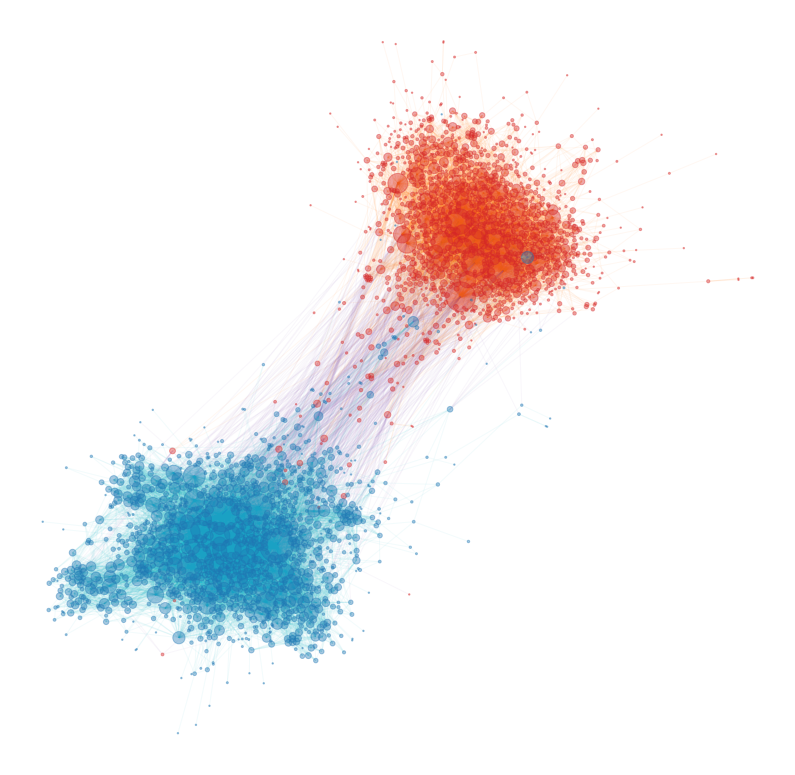

In [21]:
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=False,  # Dissuade hubs
    edgeWeightInfluence = 0.5, # Performance

    # Performance
    jitterTolerance=0.2,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=0.6,

    # Tuning
    scalingRatio=5.0,
    gravity=1.0,

    # Log
    verbose=True
)

plt.figure(figsize=(14,14))
positions = forceatlas2.forceatlas2_networkx_layout(comic_graph_GCC_undirected, pos=None, iterations=2000)
nx.draw_networkx_nodes(
    G = comic_graph_GCC_undirected,
    node_size = node_sizes,
    pos = positions, 
    node_color=node_colors,
    alpha=0.4
)
nx.draw_networkx_edges(
    G = comic_graph_GCC_undirected,
    pos = positions, 
    edge_color = edge_colors, 
    alpha=0.05
)
plt.axis('off')
plt.show()